In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import os
import time
import math
import sys
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torch.autograd import grad
from torch.nn import Parameter
cuda = torch.cuda.is_available()
import pickle as pk
import torch.optim as optim
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torchvision.transforms import transforms
from typing import Union,Tuple


import fish_models
from fish_models import utils
import robofish.io

fishes = 2

torch.cuda.is_available()

False

In [2]:
modelfilename = 'model.pth'

# Test training
n_training_iterations = 10
n_files = 1
n_timesteps = 1500
n_speed_bins = 21
n_turn_bins = 21
n_view_bins = 5
n_timesteps_simulation = 2000
batch_size = 64

"""
# Full training
n_training_iterations = 5000
n_files = None
n_timesteps = None
n_speed_bins = 63
n_turn_bins = 63
n_view_bins = 31
n_timesteps_simulation = 10000
batch_size = 64
"""

# IO Files in cm, actions in m/s
data_folder = Path("data/live_female_female/train")
test_data_folder = Path("data/live_female_female/test")

In [3]:
# ResNet uses blocks
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.kernel_size = 3

        # structure
        self.conv1 = nn.Conv1d(in_channels=16, out_channels= 16, kernel_size=self.kernel_size, stride=1, padding=1)
        self.relu1 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=1)
        self.relu2 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=1)
        self.relu3 = nn.LeakyReLU()
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=self.kernel_size, stride=2, padding=6)
        self.relu4 = nn.LeakyReLU()
        self.bn4 = nn.BatchNorm1d(16)

        # 1x1 conv filters can be used to change the dimensionality in the filter space.
        self.identity_upsample_first = nn.Sequential(nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1, stride=1),
                                          nn.BatchNorm1d(32))
        self.identity_upsample_second = nn.Sequential(nn.Conv1d(in_channels=32, out_channels=16, kernel_size=1, stride=1),
                                          nn.BatchNorm1d(16))

    def forward(self, x):
        # we use this block multipy times
        
        # save first identity
        identity1 = x.clone()
        
        x = self.conv1(x)
        x = self.relu1(x)      
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)

        # sum point
        # 1. Upsample identity size
        identity1 = self.identity_upsample_first(identity1)
        # 2. Summarize (skip connection)
        x = x + identity1
        # 3. save second identity and change size to be able to summurize in the next sum point
        identity_upsampled = self.identity_upsample_second(x)
   
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)

        # sum point
        x = x + identity_upsampled
        return x

block = ResNetBlock(in_channels=1, out_channels=1)
#block

ResNetBlock(
  (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): LeakyReLU(negative_slope=0.01)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 16, kernel_size=(3,), stride=(2,), padding=(6,))
  (relu4): LeakyReLU(negative_slope=0.01)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (identity_upsample_first): Sequential(
    (0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [4]:
# # 2d: [batch_size, num_features (aka: C * H * W)]
# use for nn.Linear() input.

class ResNet(nn.Module): 
    # layers is the list telling us how much to reuse the block in each block
    def __init__(self, block, N, batch_size):
        """ResNet is a short name for Residual Network.
        A deep convolutional neural network, 
        several layers are stacked and are trained to the task at hand. 
        The network learns several low/mid/high level features at the end of its layers. 
        
        The main innovation of ResNet is the skip connection. 
        Deep networks often suffer from vanishing gradients, 
        ie: as the model backpropagates, the gradient gets smaller and smaller. 
        
        This allows to stack additional layers and build a deeper network.
        
        Args:
            TODO
        """
        super(ResNet, self).__init__()
        self.in_channels = 1
        self.kernel_size = 3
        self.start_identity = None
        self.batch_small = 2
        self.N = N
        self.batch_size = batch_size

        # Begin
        self.conv1 = nn.Conv1d(in_channels=1, out_channels= 16, kernel_size=3, stride = 1, padding = 1)
        self.relu1 = nn.LeakyReLU()
        # nn.BatchNorm2d 4 expects 4D inputs in shape of [batch, channel, height, width]
        self.bn1 = nn.BatchNorm1d(16)

        # ResNet Layers
        # repeat 3 times for i in range(2)
        # out_channel is equal to 16 * 2 * i => 16*2^0, 16*2^1, 16*2^2 => 16, 32 and 64 out_channels
        self.layer1 = self.make_layer(block, self.N, out_channels=2)
        self.layer2 = self.make_layer(block, self.N, out_channels=4)
        self.layer3 = self.make_layer(block, self.N, out_channels=8)

        # End
        self.conv_end = nn.Conv1d(in_channels=16, out_channels= 1, kernel_size=3, stride = 1, padding = 1)
        self.flt_end = nn.Flatten()
        self.fc_end = nn.Linear(in_features=10, out_features=n_speed_bins + n_turn_bins)
        self.double()

    def forward(self, x):
    
        # Begin
        # [batch_size, seq_length] as input data -> add the channel dimension using unsqueeze

        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        # ResNet Layers forward step
        # loops inside every layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # end of inner blocks

        # Tail of the ResNet
        x = self.conv_end(x)
        x = self.flt_end(x)
        x = self.fc_end(x)
        
        return x
    
    def make_layer(self, block, num_residual_blocks, out_channels):
        identity_downsample = None
        layers = []

        print(f'Extern loop START')
        layers.append(block(self.in_channels, out_channels))
        self.in_channels = out_channels * 2

          # intern loops for layers and skip connections
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
            print(f'Inner layer {n} is created!')

        print(f'Extern loop END')
        return nn.Sequential(*layers)

    
d_mod = ResNet(ResNetBlock, N=1, batch_size=batch_size)
#d_mod

Extern loop START
Extern loop END
Extern loop START
Extern loop END
Extern loop START
Extern loop END


In [5]:
class ResNetFishModel(fish_models.gym_interface.AbstractModel):
    def __init__(self, speed_bins, turn_bins):
        """ResNet (Residual Network) deep convolutional neural network, 
        
        Args:
            speed_bins: The array with the float borders between speed bins
            turn_bins: The array with the float borders between turn bins
        """
        self.speed_bins = speed_bins
        self.turn_bins = turn_bins
        self.losses = []
        self.mean_loses = []
        
        self.deep_model = ResNet(ResNetBlock, N=1, batch_size=batch_size)
        
    def predict_proba(self, view: np.ndarray):
        tensor_proba = torch.tensor(np.array([view])).double()
        tensor_proba = tensor_proba.squeeze(1)
        output = self.deep_model(tensor_proba)
        return output.detach().numpy() 
        
    def choose_action(self, view: np.ndarray) -> Tuple[float, float]:
        probabilities = self.predict_proba([view])
        speed_probabilities = probabilities[0, : len(self.speed_bins)]
        turn_probabilities = probabilities[0, len(self.speed_bins) :]

        speed_probabilities += np.abs(np.min(speed_probabilities))
        turn_probabilities += np.abs(np.min(turn_probabilities))

        speed_probabilities /= np.sum(speed_probabilities)
        turn_probabilities /= np.sum(turn_probabilities)

        speed = np.random.choice(self.speed_bins, p=speed_probabilities)
        turn = np.random.choice(self.turn_bins, p=turn_probabilities)

        # Double sampling (sample inside the chosen bin)
        speed += np.random.random() * np.diff(self.speed_bins)[0]
        turn += np.random.random() * np.diff(self.turn_bins)[0]

        return [speed, turn]
    

    def train(self, dset, test_dset, optimizer, criterion, max_epochs):
       
        """Binarize the binned actions and train the classifier

        Args:
            dset: An IoDataset with at least output_strings ["actions_binned", "views"]
        """

        self.poses_storage = []
        train_loader = torch.utils.data.DataLoader(
                dset,
                collate_fn=fish_models.datasets.io_dataset.IODatasetPytorchDataloaderCollateFN(
                    ["views", "actions_binned"], [torch.float64, torch.long]
                ),
                batch_size = batch_size
            )
        test_loader = torch.utils.data.DataLoader(
                test_dset,
                collate_fn=fish_models.datasets.io_dataset.IODatasetPytorchDataloaderCollateFN(
                    ["views", "actions_binned"], [torch.float64, torch.long]
                ),
                batch_size = batch_size
            )
        
        
        losses = []
        mean_losses = []        
        batch_total = len(train_loader)
        
        for epoch in range(max_epochs):
            samples_total = 0
            samples_correct = 0
            test_samples_total = 0
            test_samples_correct = 0
            for batch_idx,batch in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = batch

                if cuda:
                    x, y = x.cuda(),y.cuda()

                output = model.deep_model(x)
                loss = criterion(output[:,:n_speed_bins], y[:,0]) + criterion(output[:,n_speed_bins:], y[:,1])
                loss.backward()
                optimizer.step()

                yhat1 = torch.argmax(output[:,:n_speed_bins], dim = 1)
                yhat2 = torch.argmax(output[:,n_speed_bins:], dim = 1)
                samples_total = 2*len(y)
                samples_correct += torch.sum(yhat1 == y[:,0])
                samples_correct += torch.sum(yhat2 == y[:,1])

                losses.append(loss.item())
                mean_losses.append(np.mean(losses))
                
                if batch_idx % 50 == 0:
                    acc = float(samples_correct)/float(samples_total)
                    
                sys.stdout.write(f'\rEpoch: {epoch:2}/{max_epochs:2} Step: {batch_idx:2}/{batch_total:2} Loss: {loss.item():10.6f} Acc: {acc:10.2%} ')

            checkpoint = {
                'model_state_dict': model.deep_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'losses': losses
            }
            self.savemodel(checkpoint)
        
        print('\nFinished Training')
        self.losses = losses
        self.mean_losses = mean_losses

        return losses, mean_losses
    
    def savemodel(self,checkpoint):    
        checkpoint_path = os.path.join(modelfilename)
        with open(checkpoint_path, 'wb') as f:
            pk.dump(checkpoint, f)


""" Find the 0.5% percentile and 99.5% percentile of the data to set the bins. """

# Create the bins. The values come from the quantiles and testing.
speed_bins = np.linspace(-2, 20, n_speed_bins)
turn_bins = np.linspace(-10, 10, n_turn_bins)

# ! CREATE MODEL !

model = ResNetFishModel(speed_bins, turn_bins)

Extern loop START
Extern loop END
Extern loop START
Extern loop END
Extern loop START
Extern loop END


In [6]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=n_view_bins,
            n_fish_bins=n_view_bins,
            fov_angle_fish_bins= 2 * np.pi,
            fov_angle_wall_raycasts=2 * np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )


In [7]:
# Create the dataset. When using actions_binned, the borders are neccessary.
dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["actions", "actions_binned", "views"],
    reduce_dim=2,
    max_files=n_files,
    max_timesteps=n_timesteps,
    speed_bin_borders=speed_bins,
    turn_bin_borders=turn_bins,
)
test_dset = fish_models.datasets.io_dataset.IoDataset(
    test_data_folder,
    raycast,
    output_strings=["actions", "actions_binned", "views"],
    reduce_dim=2,
    max_files=n_files,
    max_timesteps=n_timesteps,
    speed_bin_borders=speed_bins,
    turn_bin_borders=turn_bins,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

(2, 1500, 2)
(2, 1500, 3)
Calculating views from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Status of IoDataset:
The first 3 dimensions are reduced from (1, 2, 1500) to (3000)
actions	(3000, 2):	consisting of speed [cm/s] and turn [rad/s].
actions_binned	(3000, 2):	consisting of speed [discretized into 20 bins] and turn [discretized into 20 bins]
views	(3000, 10):	5 fish_bins and 5 wall ray casts.

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

(2, 1500, 2)
(2, 1500, 3)
Calculating views from 1 files.


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Status of IoDataset:
The first 3 dimensions are reduced from (1, 2, 1500) to (3000)
actions	(3000, 2):	consisting of speed [cm/s] and turn [rad/s].
actions_binned	(3000, 2):	consisting of speed [discretized into 20 bins] and turn [discretized into 20 bins]
views	(3000, 10):	5 fish_bins and 5 wall ray casts.



In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.deep_model.parameters(), lr = 1e-3)

In [9]:
start = time.time()
losses, mean_losses = model.train(dset, test_dset, optimizer, criterion, max_epochs=200)
end = time.time()
print(f'\nTraining took {end - start}s')


Epoch: 199/200 Step: 46/47 Loss:   2.623365 Acc:     43.75% 
Finished Training

Training took 604.0158252716064s


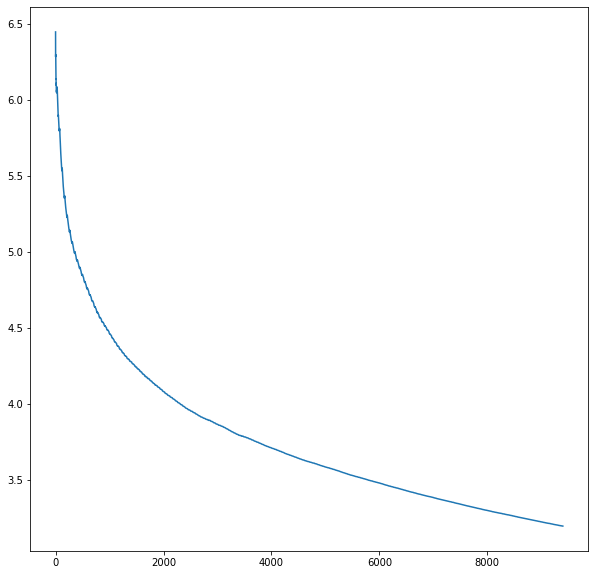

In [10]:
plt.figure(figsize=(10,10))
plt.plot(model.mean_losses)

100%|██████████| 1999/1999 [00:32<00:00, 61.86it/s]


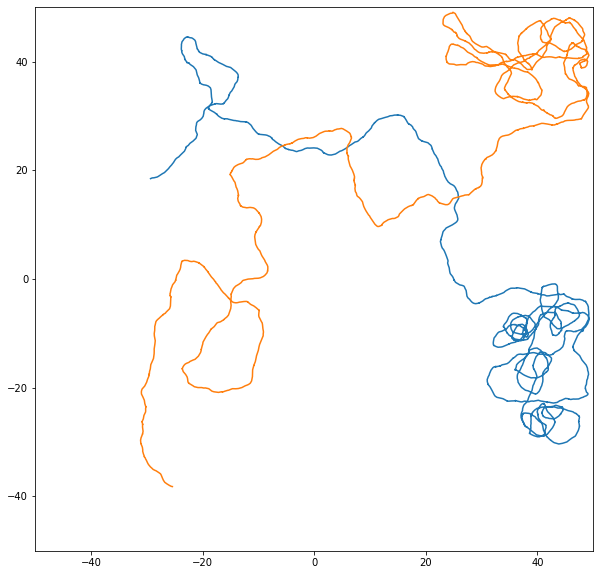

In [11]:
generator = fish_models.gym_interface.TrackGeneratorGym(
    model, [100,100], 25, raycast=raycast
)

track = generator.create_track(n_guppies=fishes, trackset_len=n_timesteps_simulation)

f = generator.as_io_file(track)
f.save_as("output/resnet.hdf5")

plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [12]:
def trajectory_generator(model_name, model, raycast, dset):
    generator = fish_models.gym_interface.TrackGeneratorGym(
    model, dset.world_size, dset.frequency, raycast=raycast
    )
    # Generate raycast file
    # initial_poses = dset.poses[0, :, 0]
    for i in range(50):
        timesteps = 10000
        track = generator.create_track(2, timesteps)
        f = generator.as_io_file(track)
        f.save_as("output/{}_modeldata/__generated{}.hdf5".format(model_name, str(i)))

In [13]:
trajectory_generator("ResNet", model, raycast, dset)

100%|██████████| 9999/9999 [02:18<00:00, 71.95it/s]
